In [68]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

# from tensorboardX import SummaryWriter
# writer = SummaryWriter()

from torchvision import models

# 1. 데이터 불러오기

In [69]:
# MEAN = (0.485, 0.456, 0.406) # 해당 데이터는 정규화시 사용되는 평균값으로, 실제 데이터의 평규값을 구해야합니다.
# STD = (0.229, 0.224, 0.225)  # 해당 데이터는 정규화시 사용되는 표준편차값으로, 실제 데이터의 표준편차값 구해야합니다.

transforms_train = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    RandomHorizontalFlip(p=0.5),        # 과적합을 막기 위해 이미지를 랜덤으로 좌우 대칭을 변환합니다.
    transforms.Grayscale(),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    transforms.Grayscale(),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

# ImageFolder 함수를 사용하여 이미지를 불러옵니다.
# train 폴더 내부에는 내가 분류하고 싶은 이미지별로 폴더 정리가 되어있어야 합니다
# 이 프로젝트에서는 [Normal, PNEUMONIA] 두개의 폴더로 분류가 되어있습니다.
# Normal 은 label 0번, PNEUMONIA 은 label 1번으로 라벨링됩니다.
# ImageFolder 함수는 이미지를 불러오는 동시에, 폴더 위치별로 정답 데이터가 라벨링 됩니다.
train_datasets = datasets.ImageFolder(root="data/train", transform=transforms_train)
test_datasets = datasets.ImageFolder(root="data/test", transform=transforms_test)

## 데이터 확인해보기

### 학습 데이터 수 확인

In [70]:
len(train_datasets) 

5216

### 분류할 클래스 리스트 보기

In [71]:
train_datasets.classes

['NORMAL', 'PNEUMONIA']

### 이미지 그리기

In [72]:
import numpy as np

# def denormalize(image, mean, std):
#     mean = torch.tensor(mean).view(3, 1, 1)
#     std = torch.tensor(std).view(3, 1, 1)
#     return image * std + mean

def view_img(tensor_image, title="title", cmap=None):
    """
    PyTorch 텐서(Tensor)를 시각화하는 함수
    """
    # 텐서를 넘파이 배열로 변환
    img_data = tensor_image.numpy()

    # 이미지 차원 순서 변경
    # PyTorch: (채널, 높이, 너비) -> Matplotlib: (높이, 너비, 채널)
    plt.imshow(np.transpose(img_data, (1, 2, 0)), cmap=cmap)

    # 이미지에 제목을 설정하고 화면에 표시
    plt.title(title)
    plt.show()

### + 튜플 데이터 타입에 대해서

In [73]:
tu = ('김서영', 99)
item0 = tu[0]
item1 = tu[1]
print(item0, item1)

name, year = tu
print(name, year)

김서영 99
김서영 99


In [74]:
image, label = train_datasets[0]
print(image) # 이미지
print(label) # 0
print(train_datasets.classes[label]) # NORMAL

tensor([[[0.3728, 0.3714, 0.3713,  ..., 0.0735, 0.0784, 0.0874],
         [0.3727, 0.3710, 0.3665,  ..., 0.0737, 0.0831, 0.0867],
         [0.3636, 0.3671, 0.3661,  ..., 0.0753, 0.0829, 0.0895],
         ...,
         [0.2362, 0.2354, 0.2343,  ..., 0.1090, 0.1141, 0.1160],
         [0.3225, 0.3196, 0.3163,  ..., 0.1332, 0.1359, 0.1356],
         [0.4254, 0.4246, 0.4201,  ..., 0.1752, 0.1761, 0.1773]]])
0
NORMAL


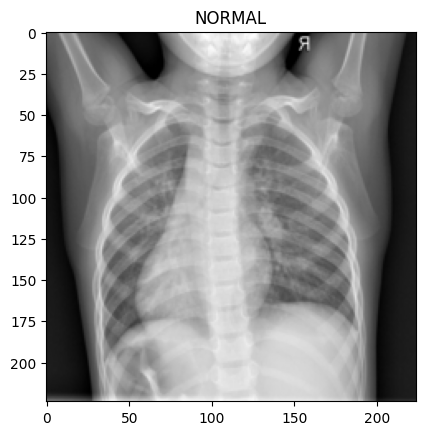

In [75]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

In [76]:
image, label = train_datasets[5000]
print(image) # 이미지
print(label) # 1
print(train_datasets.classes[label]) # PNEUMONIA

tensor([[[0.0000e+00, 2.2410e-01, 8.4365e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.2410e-01, 8.4365e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.2404e-01, 8.4301e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.0841e-02, 8.6155e-03, 7.8671e-05,  ..., 7.8594e-05,
          8.6153e-03, 1.0842e-02],
         [1.8764e-01, 1.6593e-02, 9.2624e-05,  ..., 9.2533e-05,
          1.6591e-02, 1.8764e-01],
         [5.5914e-02, 8.4970e-03, 2.8534e-05,  ..., 2.8506e-05,
          8.4965e-03, 5.5913e-02]]])
1
PNEUMONIA


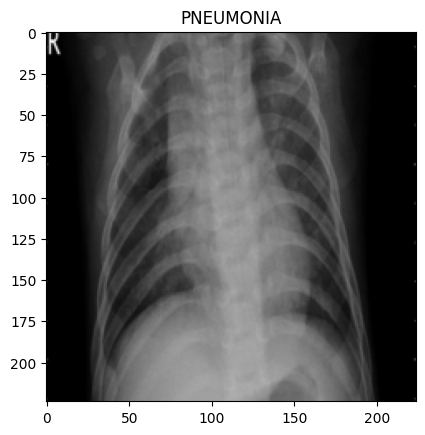

In [77]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

# 2. 데이터 배치사이즈로 분리하기

In [78]:
# DataLoader 를 사용하여 데이터를 나눈다
# batch_size 몇 개씩 그룹 지을지 정한다
# shuffle 데이터를 순서대로 나누는 것이 아니라 랜덤으로 섞어서 자른다 
# ⭐⭐ 학습에 영향을 줄 수 있으므로 Train Data 에는 True 로 설정 하자!
train_dataLoader = DataLoader(train_datasets, batch_size=32, shuffle=True) 
test_dataLoader = DataLoader(test_datasets, batch_size=32)

## 데이터 확인하기

tensor([[[0.1030, 0.1106, 0.1196,  ..., 0.1389, 0.1380, 0.1267],
         [0.1321, 0.1353, 0.1569,  ..., 0.1327, 0.1294, 0.1185],
         [0.1464, 0.1584, 0.1796,  ..., 0.1321, 0.1215, 0.1109],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
tensor(1)


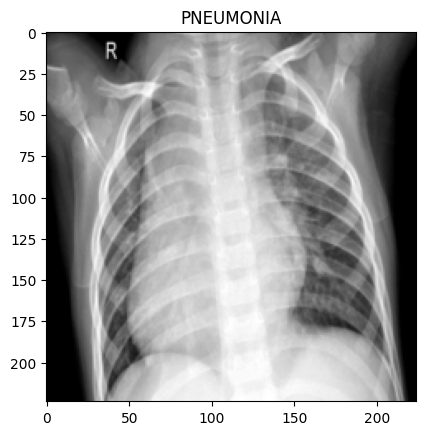

In [79]:
images, labels = next(iter(train_dataLoader)) # 튜플 (배치사이즈 만큼의 이미지들, 배치사이즈 만큼의 정답들)
print(images[0])
print(labels[0])

view_img(images[0], train_datasets.classes[labels[0]], cmap='gray')

## 데이터 형태 확인하기

In [ ]:
# 차원 수 확인하기
images.dim()

4

In [ ]:
# 배치사이즈 수만큼 분리된 데이터의 형태 확인하기
# 각 차원의 의미: [배치사이즈, 채널수, 이미지 가로 사이즈, 이미지 세로 사이즈]
images.shape

torch.Size([32, 1, 224, 224])

In [ ]:
# 이미지 한장의 데이터 형태 확인하기
images[0].shape

torch.Size([1, 224, 224])

## 데이터 그리드로 확인하기

In [ ]:
def view_grid_img(images, title):
    images_data = torchvision.utils.make_grid([image for image in images])

    print(labels)
    view_img(images_data, title)

tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0])


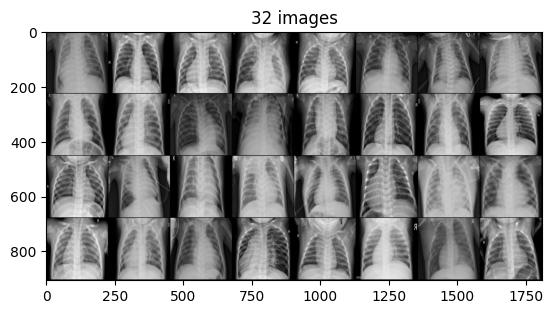

In [86]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataLoader))
images_data = torchvision.utils.make_grid([image for image in images])

print(labels)
view_img(images_data, '32 images')

# 3. 모델 정의하기/준비하기

## 1) 모델 가져오기

In [87]:
# pretrained 는 deprecated 됨
model = models.resnet34(pretrained = True)
model

c:\Potenup\DeepLearning-Pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Potenup\DeepLearning-Pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
# pretrained와 동일한 새로운 버전
from torchvision.models import ResNet34_Weights
model = models.resnet34(weights= ResNet34_Weights.DEFAULT)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 2) 파인 튜닝하기

### 동결하기

In [ ]:
for param in model.parameters():
    param.requires_grad = False

### 분류기 변경하기